
Faces dataset decompositions

This example applies to :ref:`olivetti_faces` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
:ref:`decompositions`) .


Dataset consists of 400 faces
Extracting the top 6 Eigenfaces - RandomizedPCA...
done in 1.013s


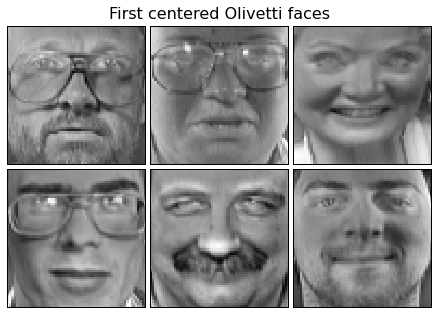

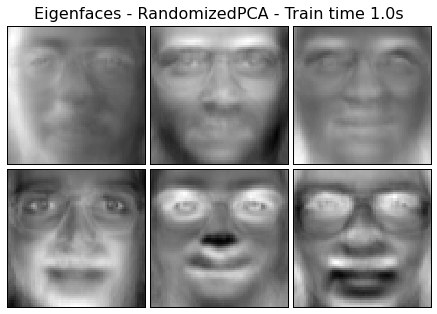

In [5]:
"""
============================
Faces dataset decompositions
============================

This example applies to :ref:`olivetti_faces` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
:ref:`decompositions`) .

"""
print(__doc__)

# Authors: Vlad Niculae, Alexandre Gramfort
# License: BSD 3 clause

import logging
from time import time

from numpy.random import RandomState
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

###############################################################################
# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)


###############################################################################
def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

###############################################################################
# List of the different estimators, whether to center and transpose the
# problem, and whether the transformer uses the clustering API.
estimators = [
    ('Eigenfaces - RandomizedPCA',
     decomposition.RandomizedPCA(n_components=n_components, whiten=True),
     True),
]


###############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

###############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_
    if hasattr(estimator, 'noise_variance_'):
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1,
                     n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

plt.show()



Faces recognition example using eigenfaces and SVMs

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

.. _LFW: http://vis-www.cs.umass.edu/lfw/

Expected results for the top 5 most represented people in the dataset::

                     precision    recall  f1-score   support

  Gerhard_Schroeder       0.91      0.75      0.82        28
    Donald_Rumsfeld       0.84      0.82      0.83        33
         Tony_Blair       0.65      0.82      0.73        34
       Colin_Powell       0.78      0.88      0.83        58
      George_W_Bush       0.93      0.86      0.90       129

        avg / total       0.86      0.84      0.85       282




Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 150 eigenfaces from 966 faces
done in 4.137s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.338s
Fitting the classifier t

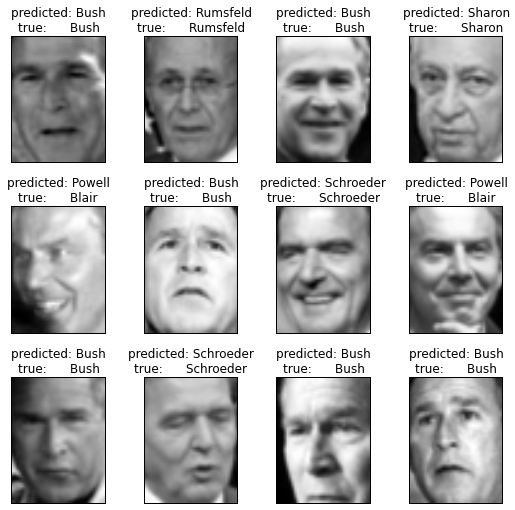

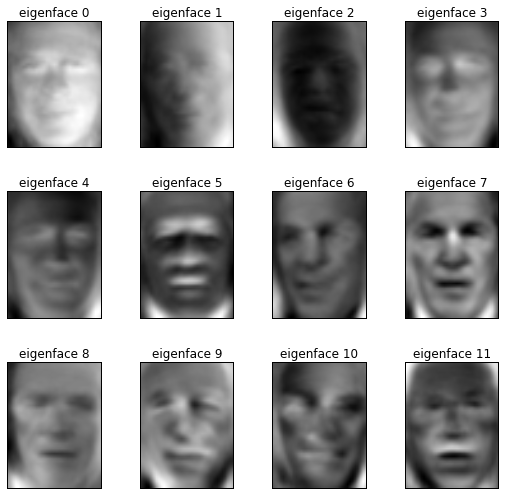

In [7]:
"""
===================================================
Faces recognition example using eigenfaces and SVMs
===================================================

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

.. _LFW: http://vis-www.cs.umass.edu/lfw/

Expected results for the top 5 most represented people in the dataset::

                     precision    recall  f1-score   support

  Gerhard_Schroeder       0.91      0.75      0.82        28
    Donald_Rumsfeld       0.84      0.82      0.83        33
         Tony_Blair       0.65      0.82      0.73        34
       Colin_Powell       0.78      0.88      0.83        58
      George_W_Bush       0.93      0.86      0.90       129

        avg / total       0.86      0.84      0.85       282



"""
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC


print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


###############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)


###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


###############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='auto'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


###############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()
